In [34]:
# core libraries
import pandas as pd
import numpy as np

# sklearn utilities
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler


# sklearn models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# get the target column
set(train.columns) - set(test.columns)

{'SalePrice'}

In [3]:
# get a description of the data
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [4]:
numeric_cols = train.select_dtypes(exclude='object').columns
categorical_cols = train.select_dtypes(include='object').columns
print("There are {} numerical features and {} categorical features".format(len(numeric_cols), len(categorical_cols)))

There are 38 numerical features and 43 categorical features


In [5]:
# get a summary of the missing data
null_cols = [col for col in train if train[col].isnull().any()]
print(train[null_cols].isnull().sum() * 100 / train.shape[0])

LotFrontage     17.739726
Alley           93.767123
MasVnrType       0.547945
MasVnrArea       0.547945
BsmtQual         2.534247
BsmtCond         2.534247
BsmtExposure     2.602740
BsmtFinType1     2.534247
BsmtFinType2     2.602740
Electrical       0.068493
FireplaceQu     47.260274
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
PoolQC          99.520548
Fence           80.753425
MiscFeature     96.301370
dtype: float64


In [19]:
mostly_missing_cols = [col for col in train if (train[col].isnull().sum() * 100 / train.shape[0]) > 40]
# the following features are missing across a vast majority of the data set, each also has a rather low cardinality,
# we can reasonably handle this with label encoding
for col in mostly_missing_cols:
    print(train[col].value_counts())

Grvl    50
Pave    41
Name: Alley, dtype: int64
Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: FireplaceQu, dtype: int64
Gd    3
Ex    2
Fa    2
Name: PoolQC, dtype: int64
MnPrv    157
GdPrv     59
GdWo      54
MnWw      11
Name: Fence, dtype: int64
Shed    49
Othr     2
Gar2     2
TenC     1
Name: MiscFeature, dtype: int64


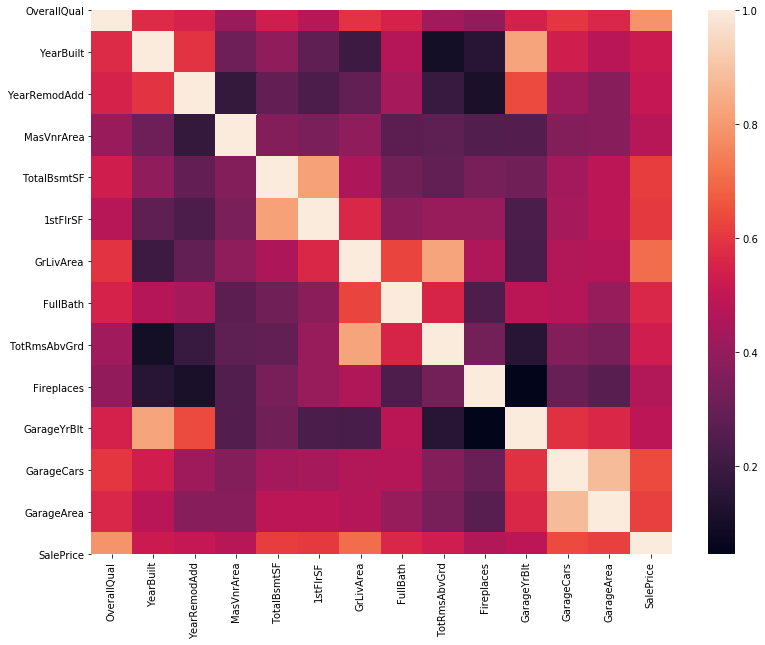

In [7]:
#ax = fig.add_subplot(111)
plt.figure(figsize=(13,10))
corr = train.corr()
mod_corr_features = [col for col in corr if abs(corr[col]['SalePrice']) >= 0.4] # get features that are moderately correlated (|r| >= 0.4)
mod_corr_matrix = corr.loc[mod_corr_features][mod_corr_features]# get correlation matrix, only including moderately correlated features
sns.heatmap(mod_corr_matrix)

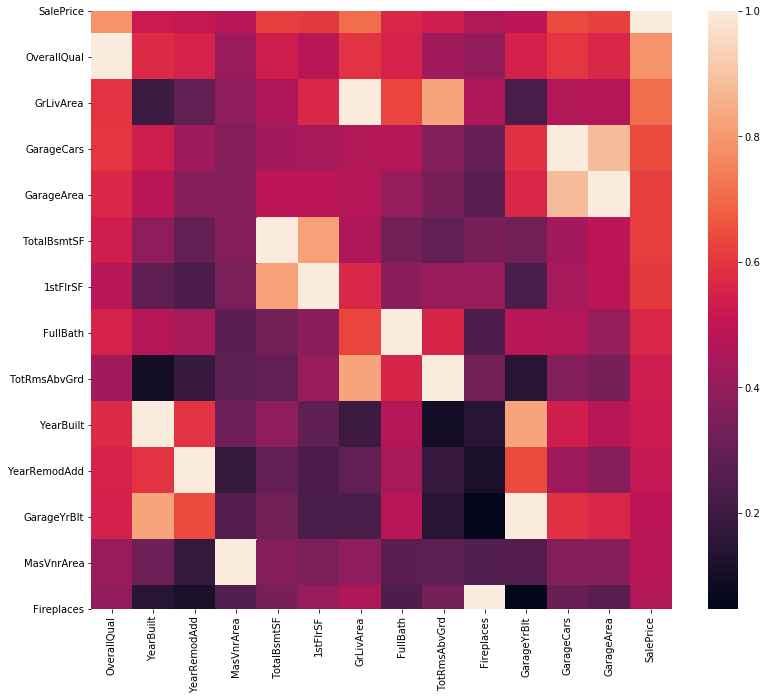

In [8]:
plt.figure(figsize=(13,11))
sns.heatmap(mod_corr_matrix.sort_values(by=['SalePrice'], ascending=False))

In [84]:
num_feature_price_range = [] # list of tuples with feature and range of mean prices for different values of the numerical feature
for feature in set(train[numeric_cols].columns) - set(['SalePrice', 'Id']):
    num_feature_price_range.append((feature, max(train.groupby(feature).SalePrice.mean())- min(train.groupby(feature).SalePrice.mean())))
num_feature_value_range = sorted(num_feature_price_range, reverse=True, key=lambda x: x[1])

In [85]:
# analyzing our target variable
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

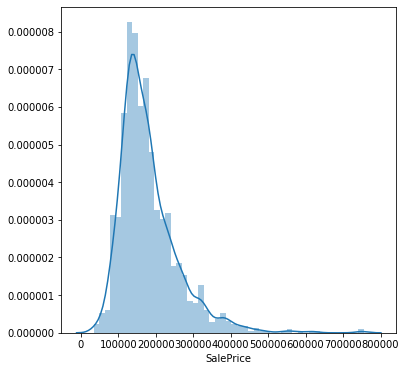

In [86]:
plt.figure(figsize=(6,6))
sns.distplot(train['SalePrice'])

* There is a rather linear relationship between each of these features and SalePrice (especially GrLivArea and 1stFlrSF), See Below

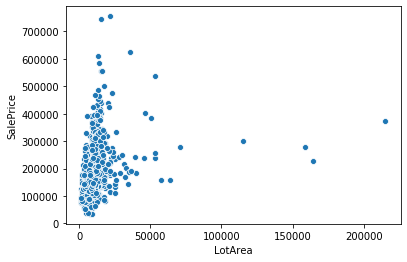

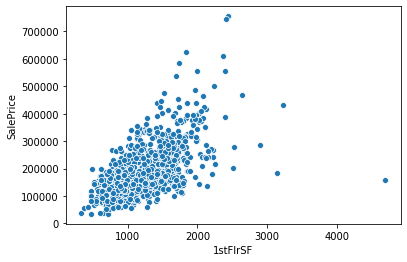

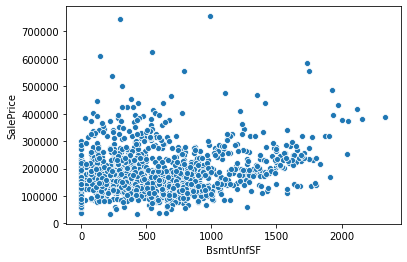

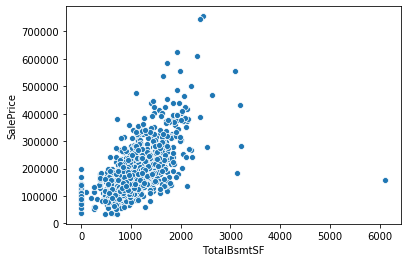

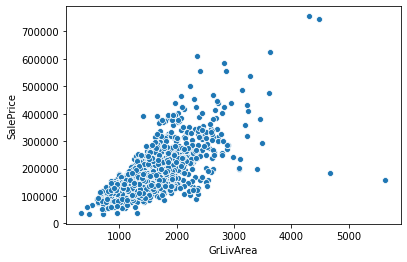

In [94]:
for feature in num_feature_value_range[0:5]:
    ax = plt.subplot()
    sns.scatterplot(x=feature[0], y='SalePrice', data=train)
    plt.show()

In [98]:
cat_feature_price_range = [] # list of tuples with feature and range of mean prices for different values of the categorical feature
for feature in set(train[categorical_cols].columns) - set(['SalePrice', 'Id']):
    cat_feature_price_range.append((feature, max(train.groupby(feature).SalePrice.mean())- min(train.groupby(feature).SalePrice.mean())))
cat_feature_value_range = sorted(cat_feature_price_range, reverse=True, key=lambda x: x[1])

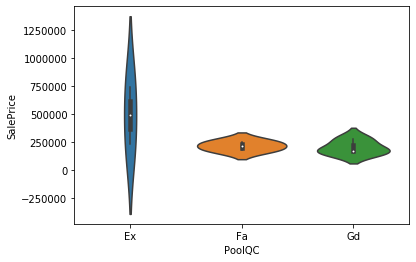

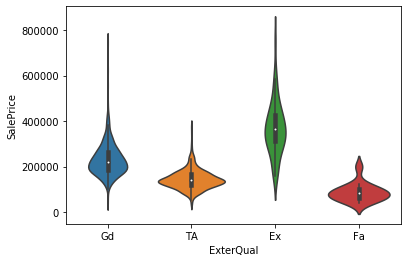

In [99]:
for feature in cat_feature_value_range[0:2]:
    ax = plt.subplot()
    sns.violinplot(x=feature[0], y='SalePrice', data=train)
    plt.show()